In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import *
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
import joblib
from joblib import load
from sklearn.preprocessing import StandardScaler
from sympy.physics.control.control_plots import matplotlib

In [2]:
df = pd.read_csv('xxxxxxx.csv', sep=";")

columns = ['class', 'dl_probabilities_0', 'dl_probabilities_1', 'dl_probabilities_2', 'surgery_class', 'oms', 'class_gender', 'age']
df = df[columns]
df.dropna(axis=0)
df.head(10)
df

,class,dl_probabilities_0,dl_probabilities_1,dl_probabilities_2,surgery_class,oms,class_gender,age
0,1,0.276197,0.401775,0.322028,1,0.0,0,74.80
1,1,0.321821,0.226534,0.451645,0,2.0,1,74.46
2,1,0.555614,0.217864,0.226522,0,2.0,0,74.15
3,2,0.222103,0.303225,0.474672,1,1.0,0,68.37
4,2,0.217938,0.228225,0.553837,1,1.0,1,73.28
...,...,...,...,...,...,...,...,...
170,2,0.212507,0.573707,0.213786,2,1.0,1,42.25
171,0,0.574714,0.212246,0.213040,0,3.0,0,73.28
172,0,0.251402,0.362665,0.385933,0,2.0,1,83.44
173,1,0.214265,0.565340,0.220395,1,0.0,0,70.35


In [3]:
combined_data = df.drop('class', axis=1)
labels = df['class']

X_np = np.array(combined_data)
sc = StandardScaler()
X_norm = sc.fit_transform(X_np)
X = X_norm

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.40, random_state=14)
print(f"Training set: {len(X_train)} patients")
print(f"Test set: {len(X_test)} patients")

Training set: 105 patients
Test set: 70 patients


In [5]:
models_params = {
    'LinearDiscriminant': {
        'model': LinearDiscriminantAnalysis(),
        'params': {
            'solver': ['svd', 'lsqr', 'eigen'], 
            'store_covariance' : [True, False], 
            'tol' : [1.0e-2, 1.0e-3, 1.0e-4]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear'], 
            'tol' : [1.0e-3, 1.0e-4], 
            'random_state' : [7], 
            'max_iter' : [100, 1000]
        }
    },
    'NeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'kd_tree']
        }
    },
    'GaussianNB': {
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-8, 1e-7]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'splitter' : ['best', 'random'],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'criterion': ['gini', 'entropy'], 
            'max_features' : ['sqrt', None]
        }
    },
    'XGBClassifier': {
        'model': xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'),
        'params': {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'min_child_weight': [1, 3],
            'subsample': [0.7, 0.9],
            'colsample_bytree': [0.7, 0.9]
        }
    }
}

In [8]:
best_models = {}
results = []

for model_name, mp in models_params.items():
    print(f"Hyperparameters optimisation for {model_name} model:")
    grid_search = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_

    y_pred = best_models[model_name].predict(X_test)
    y_pred_proba = best_models[model_name].predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Test Accuracy': accuracy,
    })

    print(f"{model_name} - Best hyperparameters: {grid_search.best_params_}")
    print(f"{model_name} - Accuracy: {accuracy:.4f}")

best_model_name = max(best_models, key=lambda name: best_models[name].score(X_test, y_test))
print(f"Best model: {best_model_name}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print(results_df[['Model', 'Test Accuracy']])

Hyperparameters optimisation for LinearDiscriminant model:
LinearDiscriminant - Best hyperparameters: {'solver': 'lsqr', 'store_covariance': True, 'tol': 0.01}
LinearDiscriminant - Accuracy: 0.8000
Hyperparameters optimisation for LogisticRegression model:
LogisticRegression - Best hyperparameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'random_state': 7, 'solver': 'liblinear', 'tol': 0.001}
LogisticRegression - Accuracy: 0.8143
Hyperparameters optimisation for NeighborsClassifier model:
NeighborsClassifier - Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
NeighborsClassifier - Accuracy: 0.7857
Hyperparameters optimisation for GaussianNB model:
GaussianNB - Best hyperparameters: {'var_smoothing': 1e-09}
GaussianNB - Accuracy: 0.8143
Hyperparameters optimisation for DecisionTreeClassifier model:
DecisionTreeClassifier - Best hyperparameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'splitter': 'random'}
DecisionTreeClas

In [ ]:
model_filename = 'xxxxxxx.joblib'
joblib.dump(best_models[best_model_name], model_filename)

In [10]:
model_ = load('xxxxxxx.joblib')
print(model_)

RandomForestClassifier(criterion='entropy', max_depth=10)


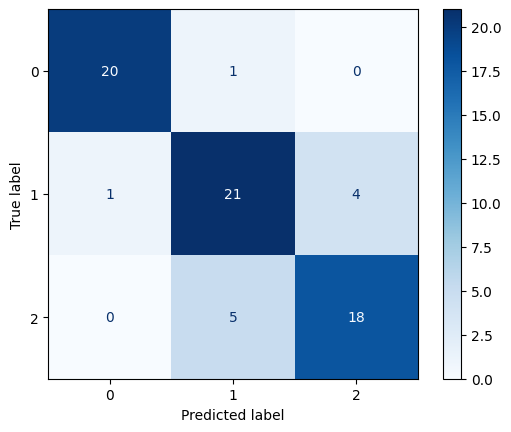

In [11]:
yhat_proba = model_.predict_proba(X_test)
yhat = np.argmax(yhat_proba, axis=1)

cm = confusion_matrix(y_test, yhat)
target_names = ['Classe 0', 'Classe 1', 'Classe 2']
report = classification_report(y_test, yhat, target_names=target_names, digits=4)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

<Figure size 640x480 with 0 Axes>

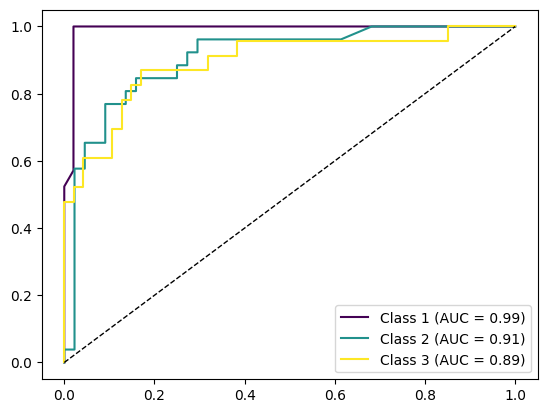

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


yhat_proba = model_.predict_proba(X_test)

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

n_classes = len(classes)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], yhat_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = plt.get_cmap('viridis', n_classes).colors
plt.style.use('default')
plt.figure(facecolor='white')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]+1} (AUC = {roc_auc[i]:.2f})", color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.legend(loc="lower right")
plt.savefig('ROC_curve_3classes_clinicaldata.png')
plt.show()